Reference: https://www.tensorflow.org/tutorials/load_data/images#create_a_dataset

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
from tensorflow.keras.applications.inception_v3 import InceptionV3

In [2]:
batchSize = 16 # 64
imgHeight = 199
imgWidth = 199

# dataPath = "datasets/food-101/food-101/images/"
dataPath = "FastFood"

trainDataset = tf.keras.utils.image_dataset_from_directory(
  dataPath,
  validation_split=0.2,
  subset="training",
  color_mode = "rgb", 
  shuffle = True,
  seed=123,
  image_size=(imgHeight, imgWidth),
  batch_size=batchSize)

valDataset = tf.keras.utils.image_dataset_from_directory(
  dataPath,
  validation_split=0.2,
  subset="validation",
  color_mode = "rgb",
  shuffle = True,
  seed=123,
  image_size=(imgHeight, imgWidth),
  batch_size=batchSize)




Found 7000 files belonging to 7 classes.
Using 5600 files for training.
Found 7000 files belonging to 7 classes.
Using 1400 files for validation.


In [3]:
valBatch = tf.data.experimental.cardinality(valDataset)
testDataset = valDataset.take((2*valBatch) // 3)
valDataset = valDataset.skip((2*valBatch) // 3)

In [4]:
df = pd.read_csv('datasets/nutrition101 (1).csv')
protein_labels = list(df['carbohydrates'])
name_labels = list(df['name'])

In [5]:
def regression_dataset(data_list):
    def convt_labels(imgs, label):
        def convert_label(label):
            return np.array([data_list[int(y_i)] for y_i in label.numpy()])
        numeric_label = tf.py_function(convert_label, [label], tf.int32)
        return imgs, numeric_label
    return convt_labels

In [6]:
trainDataset = trainDataset.map(regression_dataset(protein_labels))
testDataset = testDataset.map(regression_dataset(protein_labels))
valDataset = valDataset.map(regression_dataset(protein_labels))

In [7]:
AUTOTUNE = tf.data.AUTOTUNE

trainDataset = trainDataset.cache().prefetch(buffer_size=AUTOTUNE)
valDataset = valDataset.cache().prefetch(buffer_size=AUTOTUNE)

In [8]:
numClasses = 101

model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),


  InceptionV3(weights="imagenet", include_top=False),
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(1024, activation="sigmoid"),
  tf.keras.layers.Dense(128, activation="relu"),
  tf.keras.layers.Dropout(0.2),

  # tf.keras.layers.Conv2D(32, 11, activation='relu'),
  # tf.keras.layers.BatchNormalization(),
  # tf.keras.layers.MaxPooling2D(),

  # tf.keras.layers.Conv2D(32, 5, activation='relu'),
  # tf.keras.layers.BatchNormalization(),
  # tf.keras.layers.MaxPooling2D(),

  # tf.keras.layers.Conv2D(64, 3, activation='relu'),
  # tf.keras.layers.BatchNormalization(),
  # tf.keras.layers.MaxPooling2D(),

  # tf.keras.layers.Conv2D(64, 3, activation='relu'),
  # tf.keras.layers.BatchNormalization(),
  # tf.keras.layers.MaxPooling2D(),


  # tf.keras.layers.Dropout(0.7),

  # tf.keras.layers.Flatten(),
  
  # tf.keras.layers.Dense(514, activation='sigmoid'),
  # tf.keras.layers.Dense(256, activation='relu'),
  tf.keras.layers.Dense(1, kernel_regularizer=tf.keras.regularizers.l1_l2(0.005))
])

In [9]:
learningRate = 0.0001

model.compile(
  optimizer=tf.keras.optimizers.RMSprop(learning_rate=learningRate,
    rho=0.9,
    momentum=0.1,
    epsilon=1e-07,
    centered=True
  ),
  loss=tf.keras.losses.MSE,
  metrics=['mse', 'mae'])

In [10]:
history = model.fit(
  trainDataset,
  validation_data=valDataset,
  epochs=50,
  callbacks=[tf.keras.callbacks.ModelCheckpoint(filepath="bestInceptionRegv3FF.h5", verbose=1, save_best_only=True)]
)

Epoch 1/50
350/350 [==============================] - ETA: 0s - loss: 32.1997 - mse: 32.1378 - mae: 3.8987
Epoch 1: val_loss improved from inf to 23.75838, saving model to bestInceptionRegv3FF.h5
350/350 [==============================] - 84s 188ms/step - loss: 32.1997 - mse: 32.1378 - mae: 3.8987 - val_loss: 23.7584 - val_mse: 24.7452 - val_mae: 3.1490
Epoch 2/50
350/350 [==============================] - ETA: 0s - loss: 13.4129 - mse: 13.3684 - mae: 2.3237
Epoch 2: val_loss did not improve from 23.75838
350/350 [==============================] - 55s 158ms/step - loss: 13.4129 - mse: 13.3684 - mae: 2.3237 - val_loss: 33.3390 - val_mse: 35.0322 - val_mae: 3.3006
Epoch 3/50
350/350 [==============================] - ETA: 0s - loss: 7.9280 - mse: 7.8846 - mae: 1.7638
Epoch 3: val_loss improved from 23.75838 to 18.85300, saving model to bestInceptionRegv3FF.h5
350/350 [==============================] - 57s 164ms/step - loss: 7.9280 - mse: 7.8846 - mae: 1.7638 - val_loss: 18.8530 - val_mse

In [11]:
y_pred = model.predict(testDataset)
print(y_pred)
print(model.evaluate(testDataset))

58/58 [==============================] - 7s 66ms/step
[[19.947483 ]
 [14.800839 ]
 [19.860355 ]
 [ 4.841251 ]
 [ 7.776582 ]
 [28.929214 ]
 [ 8.855956 ]
 [ 8.8252125]
 [ 7.9240828]
 [19.781887 ]
 [ 4.790778 ]
 [ 7.661748 ]
 [14.830765 ]
 [ 5.8267436]
 [19.9077   ]
 [18.693052 ]
 [ 8.37239  ]
 [28.92849  ]
 [28.92783  ]
 [ 5.577886 ]
 [28.870708 ]
 [16.192797 ]
 [ 7.669112 ]
 [10.09203  ]
 [14.876494 ]
 [14.764681 ]
 [ 5.8336663]
 [ 8.65005  ]
 [ 8.009066 ]
 [ 7.7104764]
 [19.939297 ]
 [19.846788 ]
 [ 4.9010735]
 [19.94182  ]
 [ 5.380343 ]
 [ 7.6502643]
 [28.866102 ]
 [ 8.7816515]
 [ 6.0172253]
 [19.84084  ]
 [ 7.824258 ]
 [ 4.8477473]
 [19.904125 ]
 [ 8.716473 ]
 [ 7.635206 ]
 [ 7.2152658]
 [ 6.9939914]
 [28.702343 ]
 [20.170635 ]
 [19.848158 ]
 [ 8.809689 ]
 [ 4.7485747]
 [ 7.90622  ]
 [28.936176 ]
 [ 7.5761023]
 [22.532492 ]
 [ 8.344784 ]
 [13.4249325]
 [14.85207  ]
 [ 5.7244864]
 [ 7.9519553]
 [ 4.852428 ]
 [ 5.5160384]
 [ 7.988335 ]
 [19.91373  ]
 [ 7.494494 ]
 [ 8.714314 ]
 [ 5.902

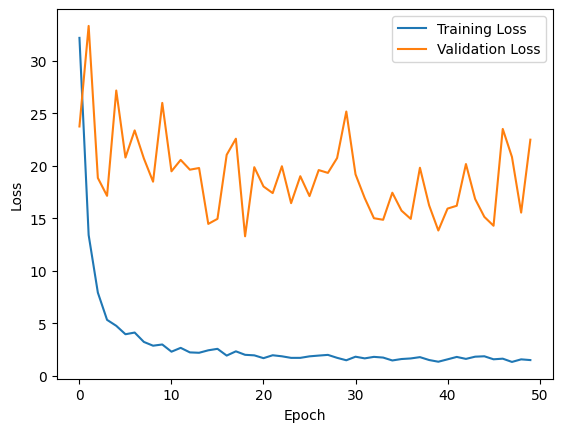

In [12]:
# Plot training and validation loss curves
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [13]:
model.save_weights("inceptionRegv3FF.h5")